In [1]:
import pandas as pd
import numpy as np

In [2]:
import tensorflow as tf
import gpflow

In [3]:
import pickle
from pathlib import Path

In [10]:
from helpers import get_scaled_df, data_to_gpr, ScalerHelper

In [5]:
import matplotlib.pyplot as plt

In [29]:
sim_path = Path("../Data/Simulation_results/Second batch/", "4_sparse_GP_500pts_12_averageYear")
scaler = pickle.load(open(Path(sim_path, "controller_scaler.pkl"), 'rb'))
scaler_helper = ScalerHelper(scaler)
model = pickle.load(open(Path(sim_path, "controller_model.pkl"), 'rb'))
df = pd.read_pickle(Path(sim_path, "controller_df.pkl"))
X_log = pickle.load(open(Path(sim_path,"controller_X_log.pkl"), 'rb'))
model_log = pickle.load(open(Path(sim_path,"controller_model_log.pkl"), 'rb'))

In [12]:
t_cols = []
w_cols = ['SolRad', 'OutsideTemp']
u_cols = ['SimulatedHeat']
y_cols = ['SimulatedTemp']

t_lags = 0
w_lags = 1
u_lags = 2
y_lags = 3

dict_cols = {
  't': (t_lags, t_cols),
  'w': (w_lags, w_cols),
  'u': (u_lags, u_cols),
 'y': (y_lags, y_cols)
}

In [31]:
len(model_log)

341

In [13]:
scaler_helper.scale_output(21)

array([0.60701006])

In [9]:
pd.DataFrame(X_log[-1])

,0,1,2,3,4,5,6
0,-1.0,-0.196272,0.439666,0.446585,0.611804,0.610780,0.609699
1,-1.0,-0.194079,0.430661,0.439666,0.609555,0.611804,0.610780
2,-1.0,-0.199561,0.433354,0.430661,0.607093,0.609555,0.611804
3,-1.0,-0.205044,0.439900,0.433354,0.606996,0.607093,0.609555
4,-1.0,-0.210526,0.447242,0.439900,0.606835,0.606996,0.607093
5,-1.0,-0.219298,0.454680,0.447242,0.606902,0.606835,0.606996
6,-1.0,-0.228070,0.462675,0.454680,0.606797,0.606902,0.606835
7,-1.0,-0.236842,0.471004,0.462675,0.606870,0.606797,0.606902
8,-1.0,-0.245614,0.607318,0.471004,0.607081,0.606870,0.606797


In [14]:
df_sc = get_scaled_df(df, dict_cols, scaler)
df_gpr = data_to_gpr(df_sc, dict_cols)

In [15]:
df_gpr

,SolRad,SolRad_1,OutsideTemp,OutsideTemp_1,SimulatedHeat,SimulatedHeat_1,SimulatedHeat_2,SimulatedTemp,SimulatedTemp_1,SimulatedTemp_2,SimulatedTemp_3
3,-1.0,-1.0,-0.307018,-0.307018,-1.000000,1.000000,1.000000,1.000000,0.968013,0.956969,0.765691
4,-1.0,-1.0,-0.307018,-0.307018,-0.993927,-1.000000,1.000000,0.140832,1.000000,0.968013,0.956969
5,-1.0,-1.0,-0.321272,-0.307018,-0.987854,-0.993927,-1.000000,-0.045578,0.140832,1.000000,0.968013
6,-1.0,-1.0,-0.335526,-0.321272,-0.981781,-0.987854,-0.993927,-0.206770,-0.045578,0.140832,1.000000
7,-1.0,-1.0,-0.349781,-0.335526,-0.975709,-0.981781,-0.987854,-0.345365,-0.206770,-0.045578,0.140832
...,...,...,...,...,...,...,...,...,...,...,...
35028,-1.0,-1.0,-0.219298,-0.224781,0.456299,0.459792,0.463963,0.608831,0.608839,0.609613,0.610534
35029,-1.0,-1.0,-0.211623,-0.219298,0.451822,0.456299,0.459792,0.609699,0.608831,0.608839,0.609613
35030,-1.0,-1.0,-0.203947,-0.211623,0.446585,0.451822,0.456299,0.610780,0.609699,0.608831,0.608839
35031,-1.0,-1.0,-0.196272,-0.203947,0.439666,0.446585,0.451822,0.611804,0.610780,0.609699,0.608831


## Multistep prediction

In [33]:
df_input = df_gpr.drop(columns = dict_cols['w'][1] + dict_cols['u'][1] + dict_cols['y'][1])
df_output = df_gpr[dict_cols['y'][1]]

In [82]:
start_idx = 500
nb_predictions = 25
N_pred = 20

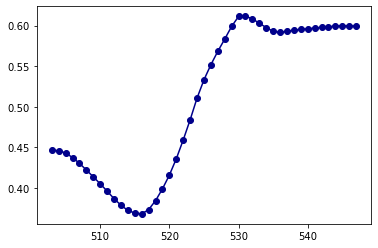

In [83]:
plt.figure()
plt.plot(df_output.iloc[start_idx:start_idx + nb_predictions + N_pred], 'o-', label = 'measured', color = 'darkblue')

In [90]:
m = model_log[-1]

Text(0.5, 1.0, 'Prediction over 20 steps')

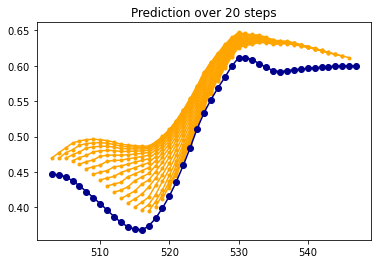

In [91]:
fig = plt.figure()

y_name = dict_cols['y'][1][0]
for idx in range(start_idx, start_idx + nb_predictions):
    df_iter = df_input.iloc[idx:(idx + N_pred)].copy()
    for idxx in range(N_pred - 1):
        idx_old = df_iter.index[idxx]
        idx_new = df_iter.index[idxx+1]
        mean, var = m.predict_f(df_iter.loc[idx_old, :].to_numpy().reshape(1, -1))
        df_iter.loc[idx_new, f'{y_name}_1'] = mean.numpy().flatten()
        for lag in range(2, dict_cols['y'][0] + 1):
            df_iter.loc[idx_new, f"{y_name}_{lag}"] = df_iter.loc[idx_old, f"{y_name}_{lag-1}"]
        
    mean_iter, var_iter = m.predict_f(df_iter.to_numpy())
    plt.plot(df_iter.index, mean_iter.numpy(), '.-', label = 'predicted', color = 'orange')
plt.plot(df_output.iloc[start_idx:start_idx + nb_predictions + N_pred], 'o-', label = 'measured', color = 'darkblue')
plt.title(f"Prediction over {N_pred} steps")
#plt.ylim([0.55, 0.65])
#plt.savefig(f"prediction_{N_pred}_steps.png")

In [77]:
gpflow.utilities.parameter_dict(m)['.kernel.lengthscales'].numpy()

array([9.78609652, 8.55323373, 2.90362544, 4.93180936, 2.90045941,
       3.29581621, 6.82360381])

In [99]:
np.params = np.empty((1, 5))
np.params

array([[17.2, 17.2, 17.2, 17.2, 24.2]])

In [98]:
scaler_helper.inverse_scale_output([0.5975, 0.6150])

array([20.88013634, 21.10070421])

In [16]:
df

,SolRad,OutsideTemp,SimulatedHeat,SimulatedTemp
0,0.00,-2.1,-5415.288115,23.000000
1,0.00,-2.1,-5415.288115,17.702812
2,0.00,-2.1,-5415.288115,15.713357
3,0.00,-2.1,-5415.288115,14.400440
4,0.00,-2.1,-5415.288115,13.350697
...,...,...,...,...
5136,440.00,1.6,30874.548732,20.361186
5137,442.25,1.8,30150.065017,20.195354
5138,444.50,2.0,29424.656508,20.072103
5139,446.75,2.2,29374.426928,19.952978


<AxesSubplot:>

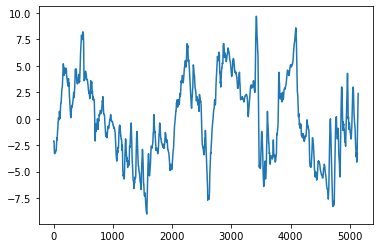

In [17]:
df['OutsideTemp'].plot()